## Modules and initializations

In [1]:
import matplotlib.pyplot as plt
import napari
import numpy as np
import os
from math import cos, sin, sqrt
from napari.settings import get_settings
from scipy.optimize import minimize
from skimage import filters
from skimage import io
from skimage.measure import regionprops, label
from skimage.morphology import disk, ball, closing, erosion
from sklearn.metrics import mean_squared_error


# Prevents automatic start of interactive event loop
get_settings().application.ipy_interactive = False


# Default colormap
cmap = 'viridis'

# Return a number of colors from the palette
def colors(number):
    # Colorblind-friendly palette
    COLOR_PALETTE = ['#e69f00',
                     '#56b4e9',
                     '#009e73',
                     '#f0e442',
                     '#0072b2',
                     '#d55e00',
                     '#cc79a7',
                     '#FFFFFF']
    
    return COLOR_PALETTE[:number]

## Calculate rotation matrix

In [2]:
def create_rotation(angle):
    return np.array([[cos(angle), -sin(angle)],
                    [sin(angle), cos(angle)]])

## Find angle between reference points

In [3]:
def rotation(angle, coords_a, coords_b):
    # Number of points
    number = coords_a.shape[0]
    
    # Initialize an array for a rotated version of coords_b
    coords_b_rotated = np.zeros((number, 2))
    
    # Rotation matrix
    rotation_matrix = create_rotation(angle)
    
    # Apply rotation (there might be a better algebraic way of computing
    # the dot-product for each vector...)
    for ii in range(number):
        coords_b_rotated[ii,:] = np.dot(rotation_matrix, coords_b[ii,:])
    
    # Calculate the mean squared error from sklearn.metrics
    MSE = mean_squared_error(coords_a, coords_b_rotated)
    
    # Calculate the square root of the  MSE
    # (smoother function, better for optimization)
    RMSE = sqrt(MSE)
    
    # Return the RMSE
    return RMSE

## Find coordinates of referance A in the space of reference B

In [4]:
def coords_of_a_in_b(ref_a, ref_b, number, prefix):
    # Empty organized array of coordinates
    coords_a = np.empty((number, 2))
    coords_b = np.empty((number, 2))
    
    # User identification of spots in reference images
    labels_a, user_coords_a = identify_spots(ref_a, number, prefix, size=120)
    labels_b, user_coords_b = identify_spots(ref_b, number, prefix, size=20)

    # Localization of spots in reference images
    loc_coords_a = localize_spots(ref_a, number, close_size=10)
    loc_coords_b = localize_spots(ref_b, number, close_size=5)

    # Connect identified spots with localized ones
    for ii in range(number):
        coords_a[ii, :], _ = find_closest_spot(user_coords_a[ii, :], loc_coords_a)
        coords_b[ii, :], _ = find_closest_spot(user_coords_b[ii, :], loc_coords_b)
        
    # Find barycentre of spots
    center_a = coords_a.mean(axis=0)
    center_b = coords_b.mean(axis=0)
    
    # Center spots
    coords_a_centered = coords_a - center_a
    coords_b_centered = coords_b - center_b
    
    # Find norm of sports
    norm_a = np.linalg.norm(coords_a_centered)
    norm_b = np.linalg.norm(coords_b_centered)
    
    # Find scaling factor
    scaling = norm_b / norm_a

    # Scale first reference
    coords_a_scaled = coords_a_centered * scaling
    
    # Find rotation angle
    res = minimize(rotation, 0, args=(coords_a_scaled, coords_b_centered), method="L-BFGS-B")
    rotation_angle = res.x[0]

    # Apply rotation angle to first reference
    rotation_matrix = np.array([[cos(-rotation_angle), -sin(-rotation_angle)],
                                [sin(-rotation_angle), cos(-rotation_angle)]])
    coords_a_rotated = (rotation_matrix@coords_a_scaled.T).T
    
    # Decenter first reference
    coords_a_decentered = coords_a_rotated + center_b
    
    return coords_a_decentered, labels_a

## Find closest spot from an array

In [5]:
def find_closest_spot(spot, spot_array):
    # Initialize return coordinates
    match = np.empty((1, spot.shape[0]))
    
    # Initialize distance to positive infinity
    distance = float('inf')
    
    # Find closest spot
    idx = 0
    for spot_ii in spot_array:
        if squared_distance(spot, spot_ii) < distance:
            match = spot_ii
            match_idx = idx
            distance = squared_distance(spot, spot_ii)
        idx += 1
    
    # Closest spot
    closest = np.copy(match)
    
    # Set matched spot in localized matrix to infinity (so it can't be found again)
    match[0] = float('inf')
    match[1] = float('inf')
    
    return closest, match_idx

## Calculate squared Euclidian norm

In [6]:
def squared_distance(spot_1, spot_2):
    return np.sum(np.square(spot_2 - spot_1))

## Localize (automatically) spots in reference image

In [7]:
def localize_spots(ref, number, close_size):
    # Initialize coordinates array
    coords = np.empty((3, 2))
    
    # Apply median filter
    ref_proc = filters.median(ref, disk(1.0))
    
    # Find threshold value
    threshold_value = filters.threshold_otsu(ref)
    
    # Apply threshold
    ref_proc = (ref > threshold_value).astype(int)
    
    # Apply closing operation
    ref_proc = closing(ref_proc, disk(close_size))

    # Apply regionprops
    properties = regionprops(label(ref_proc), ref)
    
    # Counter of spots localized
    localized = 0
    
    # Select valid centroid (area > 100 px)
    for spot in properties:
        if spot.area > 100:
            # Save spot coordinates
            coords[localized,:] = np.asarray(spot.weighted_centroid)
            
            # Increase counter
            localized += 1
    
    # Check that all the spots have been localized
    if localized != number:
        print('ERROR: Not enough spots located in reference image!')
    
    return coords

## Run Napari for user to identify reference spots in an image

In [8]:
def identify_spots(ref, number, prefix, size):
    # Initialize spot coordinates array
    points = 50 * np.ones((number, 2))
    
    # Initialize spot labels
    labels = []
    
    # Loop over the number of spots
    for ii in range(number):
        # Initialize annotations in top-left corner
        points[ii, 0] = ii * 2 * size + 2 * size
        
        # Add labels to annotations
        labels.append(prefix + str(ii+1))
    
    # Create text for annotations
    text = {'string': labels,
            'size': 6,
            'color': 'white',
            'translation': 0.75 * np.array([-size, size])}    

    # Open Napari viewer
    viewer = napari.Viewer(title='Identify spots in reference image')
    
    # Add reference image in a new layer
    ref_layer = viewer.add_image(ref, name='Reference image')
    
    # Update colormap
    ref_layer.colormap = cmap
    
    # Add annotations to points layer    
    pt_layer = viewer.add_points(points,
                                 properties={'label': labels},
                                 text=text,
                                 size=size,
                                 edge_width=.05,
                                 edge_color=colors(number),
                                 face_color='transparent',
                                 name='ROIs')

    # Change to select mode
    pt_layer.mode = 'select'
    
    # Close viewer and retrieve spot coordinates
    @viewer.bind_key('Enter')
    def complete_spot_selection(viewer):
        viewer.close()
        
    # Run Napari
    napari.run()
    
    # Return sport labels and coordinates
    return pt_layer.properties['label'], pt_layer.data

## Crop image or stack in X-Y around the center

In [9]:
def crop_around_center_2D(img, half_length):
    size = img.shape
    
    if len(size) == 2:
        crop = np.copy(img[int(size[0]/2)-half_length:int(size[0]/2)+half_length,
                           int(size[1]/2)-half_length:int(size[1]/2)+half_length])
    if len(size) == 3:
        crop = np.copy(img[:, int(size[1]/2)-half_length:int(size[1]/2)+half_length,
                           int(size[2]/2)-half_length:int(size[2]/2)+half_length])
        
    return crop

## Display transform result

In [10]:
def display_transform_result(ref, a_in_b, labels):
    # New Napari Viewer
    viewer = napari.Viewer(title='Validation')
    
    # Add reference image
    ref_layer = viewer.add_image(ref, name='Reference image')
    
    # Change colormap
    ref_layer.colormap = cmap
    
    # Number of annotations
    number = a_in_b.shape[0]
    
    # Text annotations
    text = {'string': labels.tolist(),
            'size': 6,
            'color': 'white',
            'translation': 0.75 * np.array([-20, 20])}
    
    # Add annotations
    annotation_layer = viewer.add_points(a_in_b,
                                         properties={'label': labels},
                                         text=text,
                                         size=20,
                                         edge_width=.05,
                                         edge_color=colors(number),
                                         face_color='transparent',
                                         name='ROIs')
    
    # Run Napari
    napari.run()

## Display MIP along Z axis with target annotations

In [11]:
def display_mip(stack, a_in_b, labels):
    # New Napari Viewer
    viewer = napari.Viewer(title='MIP with target annotations')
    
    # Add MIP along Z axis
    mip_layer = viewer.add_image(np.amax(stack, axis=0), name='MIP along Z axis')
    
    # Change colormap
    mip_layer.colormap = cmap
    
    # Number of annotations
    number = a_in_b.shape[0]
    
    # Text annotations
    text = {'string': labels.tolist(),
            'size': 6,
            'color': 'white',
            'translation': 0.75 * np.array([-20, 20])}
    
    # Add annotations
    annotation_layer = viewer.add_points(a_in_b,
                                         properties={'label': labels},
                                         text=text,
                                         size=20,
                                         edge_width=.05,
                                         edge_color=colors(number),
                                         face_color='transparent',
                                         name='ROIs')
    
    # Run Napari
    napari.run()

## Measure errors

In [17]:
def distance_to_target(stack, points, text):
    # Number of annotations
    number = points.shape[0]
    
    # Make a copy of the points
    points_copy = np.copy(points)
    
    # Empty array for largest identified spots
    identified_spots = np.zeros((number, 3))
    
    # Threshold and erode
    threshold_value = filters.threshold_otsu(stack)
    stack_proc = (stack > threshold_value).astype(int)
    stack_proc = erosion(stack_proc, ball(1.0))
    
    # Apply regionprops
    labels = label(stack_proc)

    # Counter of identified spots
    ii = 0
    
    # Loop over the regionprops in order of largest area
    for region in sorted(
            regionprops(labels, stack),
            key=lambda r: r.area,
            reverse=True,
    ):
        # Pick <number> spots of largest area
        if ii < number:
            identified_spots[ii, :] = region.centroid_weighted
            ii += 1
        else:
            break
    
    # Initialize error vectors
    euclidian_error = np.zeros((number,))
    x_error = np.zeros((number,))
    y_error = np.zeros((number,))
    z_error = np.zeros((number,))
    
    # Loop over the spots
    for spot in identified_spots:
        # Find closest match amongst targets
        closest_spot, idx = find_closest_spot(spot, points_copy)
        
        # Report errors
        (z_error[idx], x_error[idx], y_error[idx]) = np.absolute(spot-closest_spot)
        euclidian_error[idx] = squared_distance(spot, closest_spot)**0.5
    
    # Physical parameters
    sensor_pitch = 3.45 # [um]
    magni = 10.0
    pixel_size = sensor_pitch / magni
    
    # Plot errors
    fig = plt.figure()
    gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
    axs = gs.subplots(sharey=True)
    for ax in axs.flat:
        ax.grid()
    axs[0].set(ylabel='Abs dist to target [um]')
    axs[0].bar(text, euclidian_error * pixel_size, color=colors(number))
    axs[0].title.set_text('Euclidian distance')
    axs[1].bar(text, x_error * pixel_size, color=colors(number))
    axs[1].title.set_text('X distance')
    axs[2].bar(text, y_error * pixel_size, color=colors(number))
    axs[2].title.set_text('Y distance')
    axs[3].bar(text, z_error * pixel_size, color=colors(number))
    axs[3].title.set_text('Z distance')
    
    fig = plt.figure()
    gs = fig.add_gridspec(1, 4, hspace=0, wspace=0)
    axs = gs.subplots(sharey=True)
    for ax in axs.flat:
        ax.grid()
    axs[0].set(ylabel='Abs dist to target [px]')
    axs[0].bar(text, euclidian_error, color=colors(number))
    axs[0].title.set_text('Euclidian distance')
    axs[1].bar(text, x_error, color=colors(number))
    axs[1].title.set_text('X distance')
    axs[2].bar(text, y_error, color=colors(number))
    axs[2].title.set_text('Y distance')
    axs[3].bar(text, z_error, color=colors(number))
    axs[3].title.set_text('Z distance')

## Main

In [13]:
def main(show_validation=False, show_mip=False):
    # Folder
    folder = r'E:\PythonScripts\3i_Z_Stack'
    
    # Reference images
    ref_a = np.asarray(io.imread(os.path.join(folder, 'up_ref.tif')))
    ref_b = np.asarray(io.imread(os.path.join(folder, 'sub_ref.tif')))
    
    # Crop reference b
    crop_half_length = 100
    ref_b = crop_around_center_2D(ref_b, crop_half_length)
    
    # Number of spots
    number = 3
    
    # Label prefix
    prefix = 'S'
    
    # Find transform
    a_in_b, labels = coords_of_a_in_b(ref_a, ref_b, number, prefix)
    
    # Display transform result
    if show_validation:
        display_transform_result(ref_b, a_in_b, labels)

    # Stack
    stack = io.imread(os.path.join(folder, 'stack.tif'))

    # Crop stack
    crop = crop_around_center_2D(stack, crop_half_length)

    # Apply median filter to crop
    crop = filters.median(crop, ball(1))
    
    # Display MIP
    if show_mip:
        display_mip(crop, a_in_b, labels)
    
    # Open Napari viewer
    viewer = napari.Viewer()
    
    # Add stack in new layer
    stack_layer = viewer.add_image(crop, name='Stack')
    
    # Update colormap
    stack_layer.colormap = 'viridis'
    
    # Z coordinates
    z_column = np.empty((3, 1))
    z_column[0] = 50
    z_column[1] = 20
    z_column[2] = 80
    
    # Coordinates of annotations in 3D
    points = np.concatenate((z_column, a_in_b), axis=1)
    
    # Localization of spots in stack
    distance_to_target(crop, points, labels.tolist())

    # Add annotations in new layer
    viewer.dims.ndisplay = 3
    text = {'string': labels.tolist(),
            'size': 16,
            'color': 'white',
            'anchor': 'upper_right',
            'translation': np.array([0, 10, 10])}
    annotation_layer = viewer.add_points(points,
                                         properties={'label': labels},
                                         face_color=colors(number),
                                         size=10,
                                         shading='spherical',
                                         edge_width=0,
                                         opacity=0.6)
    text_layer = viewer.add_points(points,
                                   name='Text',
                                   text=text,
                                   face_color='transparent',
                                   edge_width=0)
    
    # Run Napari
    napari.run()

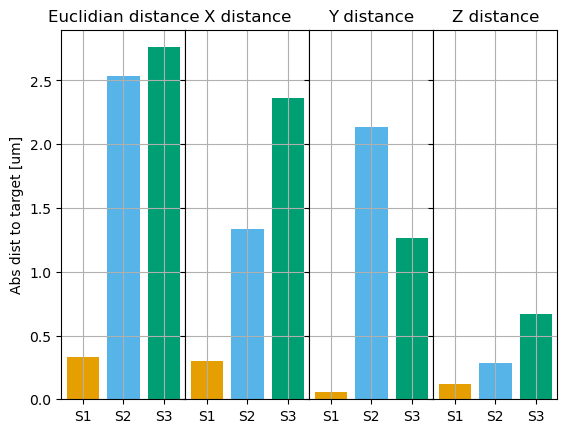

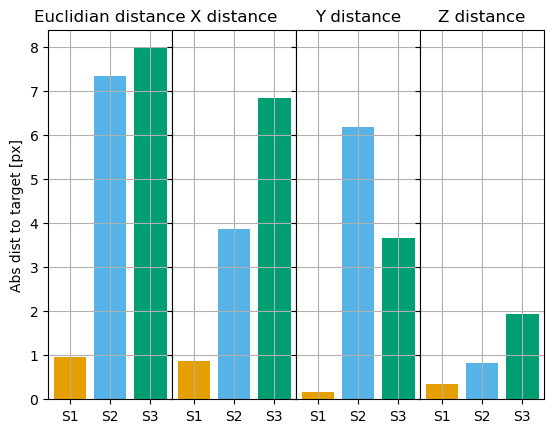

In [18]:
if __name__ == '__main__':
    main(show_validation=False, show_mip=False)